In [1]:
import gpxpy
import mplleaflet
import pandas as pd
import numpy as np
from pykalman import KalmanFilter

import matplotlib.pyplot as plt
#plt.rcParams['axes.xmargin'] = 0.1
#plt.rcParams['axes.ymargin'] = 0.1
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")

%load_ext autoreload
%autoreload 2

In [2]:
with open('../gpx/3-laender-giro.gpx') as fh:
    gpx_file = gpxpy.parse(fh)
    
segment = gpx_file.tracks[0].segments[0]

### Let's try to correct some unrealistic things like

In [3]:
segment.get_uphill_downhill()

UphillDownhill(uphill=4446.100000000043, downhill=4439.100000000031)

### ... and speed records on a bikecycle

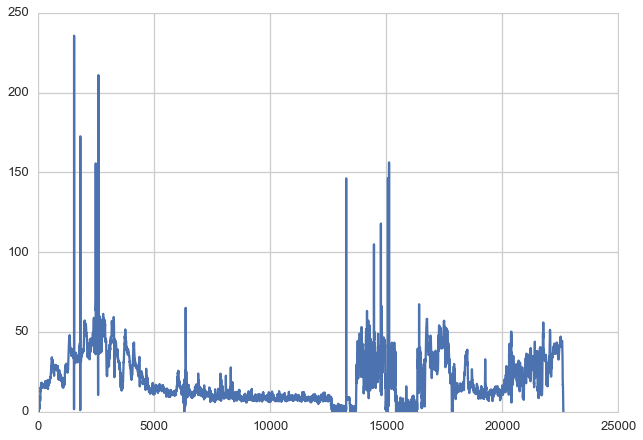

In [4]:
segment.points[0].speed = 0.0
segment.points[-1].speed = 0.0
gpx_file.add_missing_speeds()

speed = np.array([p.speed for p in segment.points])*3.6
plt.plot(speed)

### But we start with a little bit of data wrangling

In [5]:
coords = pd.DataFrame([{'idx': i,
                        'lat': p.latitude, 
                        'lon': p.longitude, 
                        'ele': p.elevation,
                        'speed': p.speed,
                        'time': p.time} for i, p in enumerate(segment.points)])
coords.set_index('time', inplace=True)
coords.head()

,ele,idx,lat,lon,speed
time,,,,,
2016-06-26 04:31:27,1343.0,0,46.889062,10.502119,0.000000
2016-06-26 04:31:28,1343.0,1,46.889062,10.502119,0.018335
2016-06-26 04:31:29,1343.0,2,46.889062,10.502119,0.539877
2016-06-26 04:31:30,1344.0,3,46.889065,10.502119,1.062646
2016-06-26 04:31:31,1345.0,4,46.889068,10.502121,1.123059


In [6]:
coords.tail()

,ele,idx,lat,lon,speed
time,,,,,
2016-06-26 10:49:01.117,1350.0,22627,46.888570,10.502008,0.711726
2016-06-26 10:49:02.117,1350.0,22628,46.888573,10.502010,0.278200
2016-06-26 10:49:03.117,1350.0,22629,46.888574,10.502012,0.139867
2016-06-26 10:49:04.117,1350.0,22630,46.888574,10.502013,0.079782
2016-06-26 10:49:05.117,1350.0,22631,46.888575,10.502012,0.000000


### Oh... time interval is not always 1sec, let's do something about that and round to nearest sec

In [7]:
coords.index = np.round(coords.index.astype(np.int64), -9).astype('datetime64[ns]')
coords.tail()

,ele,idx,lat,lon,speed
2016-06-26 10:49:01,1350.0,22627,46.888570,10.502008,0.711726
2016-06-26 10:49:02,1350.0,22628,46.888573,10.502010,0.278200
2016-06-26 10:49:03,1350.0,22629,46.888574,10.502012,0.139867
2016-06-26 10:49:04,1350.0,22630,46.888574,10.502013,0.079782
2016-06-26 10:49:05,1350.0,22631,46.888575,10.502012,0.000000


### Do we have signal loss?

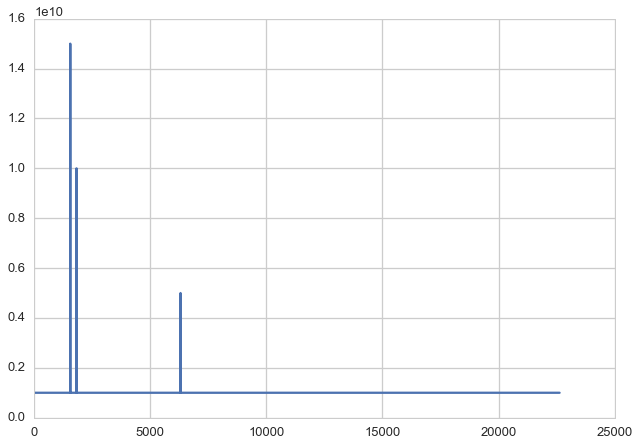

In [8]:
plt.plot(np.diff(coords.index))

### Okay, let's resample with 1 sec intevals and fill up with NaN

In [9]:
coords = coords.resample('1S').asfreq()
coords.loc[coords.ele.isnull()].head()

,ele,idx,lat,lon,speed
2016-06-26 04:57:17,NaN,NaN,NaN,NaN,NaN
2016-06-26 04:57:18,NaN,NaN,NaN,NaN,NaN
2016-06-26 04:57:19,NaN,NaN,NaN,NaN,NaN
2016-06-26 04:57:20,NaN,NaN,NaN,NaN,NaN
2016-06-26 04:57:21,NaN,NaN,NaN,NaN,NaN


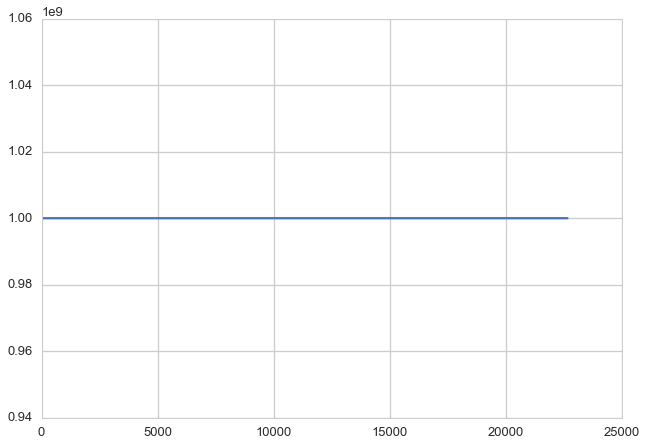

In [10]:
plt.plot(np.diff(coords.index))

### Almost done. Now convert to good old numpy array and mask NaNs

In [11]:
measurements = np.ma.masked_invalid(coords[['lon', 'lat', 'ele']].values)

### So where did I lose the GPS signal?

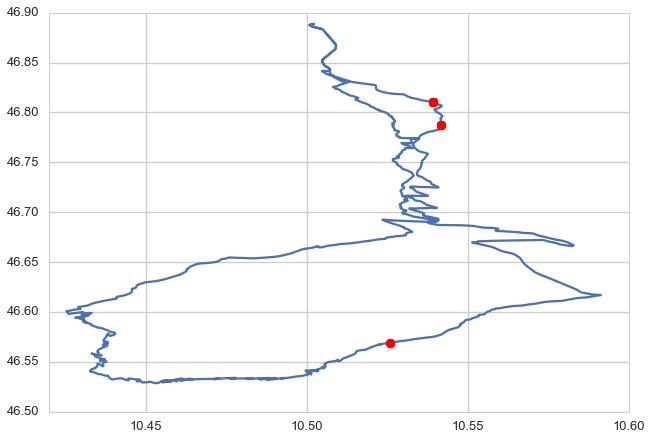

In [12]:
fig = plt.figure()
plt.plot(measurements[:,0], measurements[:,1])
filled_coords = coords.fillna(method='pad').ix[coords.ele.isnull()]
plt.plot(filled_coords['lon'].values, filled_coords['lat'].values, 'ro')

### Let's set up the Kalman Filter

In [13]:
F = np.array([[1, 0, 0, 1, 0, 0],
              [0, 1, 0, 0, 1, 0],
              [0, 0, 1, 0, 0, 1],
              [0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 1]])

H = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0]])

R = np.diag([1e-4, 1e-4, 100])**2

initial_state_mean = np.hstack([measurements[0, :], 3*[0.]])
# works initial_state_covariance = np.diag([1e-3, 1e-3, 100, 1e-4, 1e-4, 1e-4])**2
initial_state_covariance = np.diag([1e-4, 1e-4, 50, 1e-4, 1e-4, 1e-4])**2

In [14]:
kf = KalmanFilter(transition_matrices=F, 
                  observation_matrices=H, 
                  observation_covariance=R,
                  initial_state_mean=initial_state_mean,
                  initial_state_covariance=initial_state_covariance,
                  em_vars=['transition_covariance'])

In [15]:
# Careful here, this takes several hours!
#kf = kf.em(measurements, n_iter=1000)

In [16]:
# Just run this cell instead of the one above (it is the same result)
Q = np.array([[  3.17720723e-09,  -1.56389148e-09,  -2.41793770e-07,
                 2.29258935e-09,  -3.17260647e-09,  -2.89201471e-07],
              [  1.56687815e-09,   3.16555076e-09,   1.19734906e-07,
                 3.17314157e-09,   2.27469595e-09,  -2.11189940e-08],
              [ -5.13624053e-08,   2.60171362e-07,   4.62632068e-01,
                 1.00082746e-07,   2.81568920e-07,   6.99461902e-05],
              [  2.98805710e-09,  -8.62315114e-10,  -1.90678253e-07,
                 5.58468140e-09,  -5.46272629e-09,  -5.75557899e-07],
              [  8.66285671e-10,   2.97046913e-09,   1.54584155e-07,
                 5.46269262e-09,   5.55161528e-09,   5.67122163e-08],
              [ -9.24540217e-08,   2.09822077e-07,   7.65126136e-05,
                 4.58344911e-08,   5.74790902e-07,   3.89895992e-04]])
kf.transition_covariance = Q

### Compare now our measurements with a smoothed track

In [17]:
state_means, state_vars = kf.smooth(measurements)

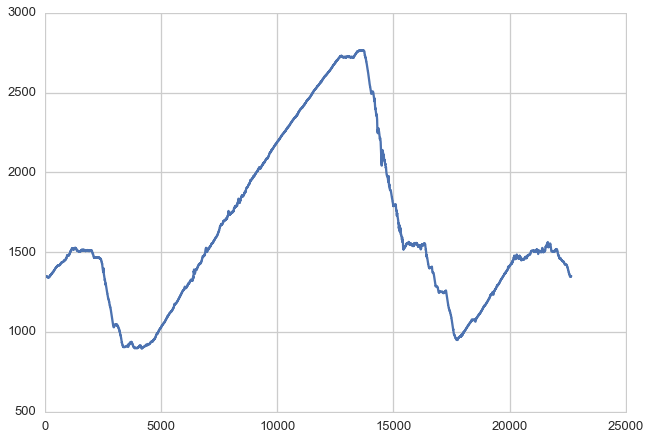

In [18]:
plt.plot(measurements[:,2])

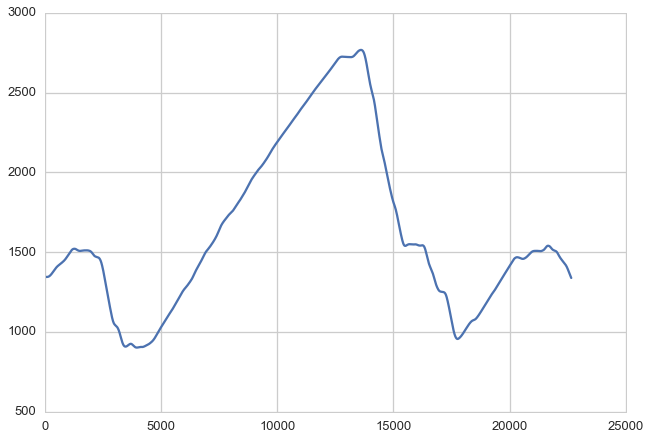

In [19]:
plt.plot(state_means[:,2])

### Let's write the smoothed data back into our dataframe and GPX file

In [20]:
coords.ix[:, ['lon', 'lat', 'ele']] = state_means[:,:3]
orig_coords = coords.ix[~coords['idx'].isnull()].set_index('idx')

In [21]:
for i, p in enumerate(segment.points):
    p.speed = None
    p.elevation = orig_coords.at[float(i),'ele']
    p.longitude = orig_coords.at[float(i),'lon']
    p.latitude = orig_coords.at[float(i),'lat']

In [22]:
segment.get_uphill_downhill()

UphillDownhill(uphill=2677.5337975594148, downhill=2683.540683811415)

### Yes, that sounds much more realistic!!! Let's also check the speed

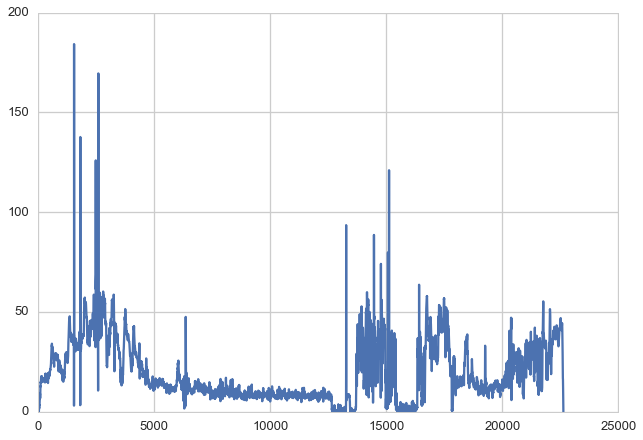

In [23]:
segment.points[0].speed = 0.0
segment.points[-1].speed = 0.0
gpx_file.add_missing_speeds()

speed = np.array([p.speed for p in segment.points])*3.6
plt.plot(speed)

### Arrrggh!!! Still not good! What the heck is going on?

In [24]:
high_speed = np.argsort(speed)[:-40:-1]

In [25]:
segment.points = [p for i, p in enumerate(segment.points) if np.min(np.abs(high_speed - i)) > 30]
for p in segment.points:
    p.speed = None

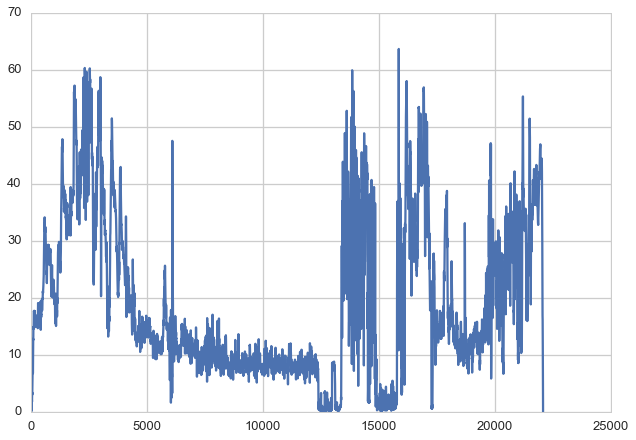

In [26]:
segment.points[0].speed = 0.0
segment.points[-1].speed = 0.0
gpx_file.add_missing_speeds()

speed = np.array([p.speed for p in segment.points])*3.6
plt.plot(speed)

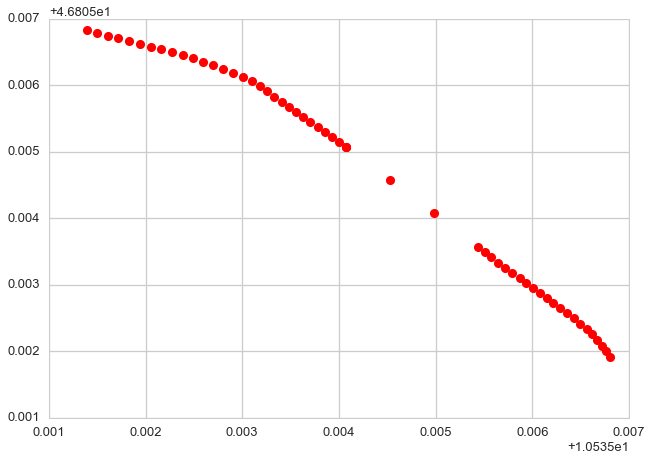

In [27]:
plt.plot(measurements[1520:1590,0], measurements[1520:1590,1], 'ro')

In [28]:
state_means, state_vars = kf.smooth(state_means[:,:3])

In [29]:
gps_speed = np.hypot(state_means[:,3], state_means[:,4])

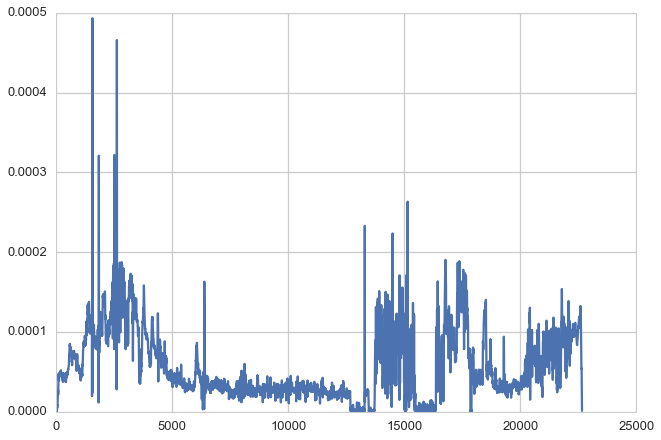

In [30]:
plt.plot(gps_speed)

In [31]:
np.argsort(gps_speed)[:-30:-1]

array([ 1566,  1567,  2621,  2622,  1565,  2620,  1568,  2623,  1564,
        2619,  2509,  1844,  1845,  2508,  2510,  2624,  1843,  1569,
        1846,  1563, 15147,  2507, 15148,  2618,  2511, 13301, 13300,
       14498, 14499])

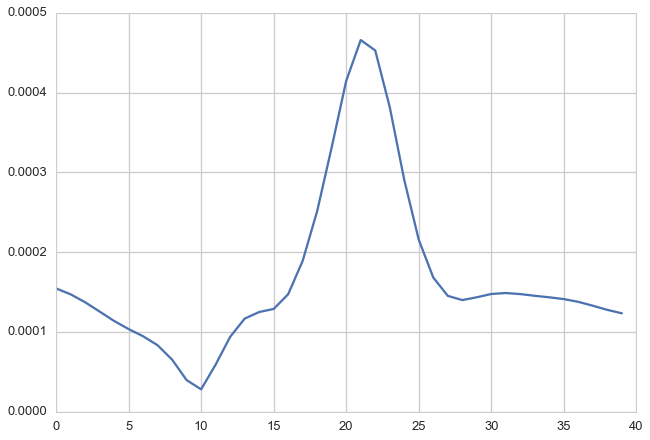

In [32]:
plt.plot(gps_speed[2600:2640])

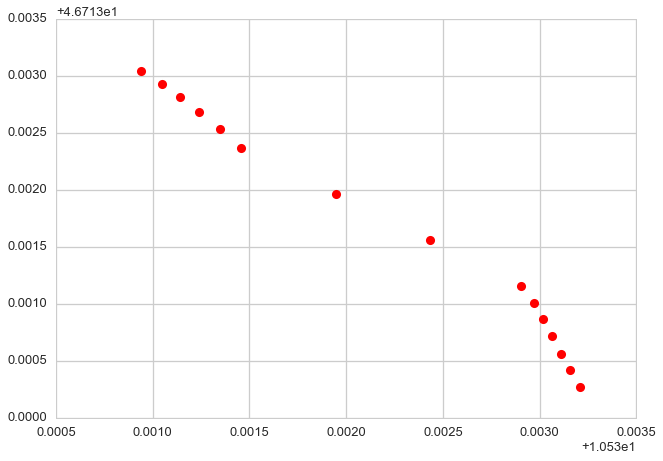

In [33]:
plt.plot(measurements[2615:2630,0], measurements[2615:2630,1], 'ro')

In [34]:
segment.points[1545:1558] # speed is in m/s

[GPXTrackPoint(46.8042308622, 10.5408500455, elevation=1510.0056107715238, time=datetime.datetime(2016, 6, 26, 4, 58, 31), speed=8.439037833149413),
 GPXTrackPoint(46.8041630763, 10.5408018494, elevation=1510.0265038298235, time=datetime.datetime(2016, 6, 26, 4, 58, 32), speed=8.400138988458348),
 GPXTrackPoint(46.8040977272, 10.5407457315, elevation=1510.047886100203, time=datetime.datetime(2016, 6, 26, 4, 58, 33), speed=8.561300612609994),
 GPXTrackPoint(46.8040341799, 10.5406789307, elevation=1510.06985481425, time=datetime.datetime(2016, 6, 26, 4, 58, 34), speed=8.909300994498182),
 GPXTrackPoint(46.8039721099, 10.5406004997, elevation=1510.0924455906486, time=datetime.datetime(2016, 6, 26, 4, 58, 35), speed=9.257684987014457),
 GPXTrackPoint(46.8039122859, 10.5405131951, elevation=1510.1155776740793, time=datetime.datetime(2016, 6, 26, 4, 58, 36), speed=9.426743542611185),
 GPXTrackPoint(46.8038552275, 10.5404209384, elevation=1510.1390476993906, time=datetime.datetime(2016, 6, 26

### Looking at these numbers the sensors seems to be quite intert! Let's just eliminate unlikely points by using the covariance given by the Kalman filter!

In [35]:
bad_readings = np.argsort(np.trace(state_vars[:,:2,:2], axis1=1, axis2=2))[:-100:-1]
cleansed_measurements = np.delete(measurements, bad_readings, axis=0)

In [36]:
np.argsort(np.trace(state_vars[:,:2,:2], axis1=1, axis2=2))[:-100:-1]

array([22658, 22657,     0, 22656, 22655, 22654, 22653,     4, 22652,
           3, 22651, 22650, 22649, 22648, 22647,     8, 22646, 22645,
       11150, 17913, 11752, 19156, 22472,  6995,  8650, 15842,  1763,
       21877, 15796, 15270, 14849,  4073,  6910, 19069,  7273, 16982,
       13094, 12972,  6610, 22185,  8998, 19731, 10283,  5415, 13739,
       12543, 21892,  4264,  5629,  6666,  7998, 16999, 17870,  5303,
       13221,  7697,  4657,  6917,  5517,  9270, 12065, 17497,  9356,
       15374, 20417,  3876,  4081, 19863,  5922,   743, 17729,  8715,
       10248, 21417,  6179,  2933,  1703,  2896,  3782, 10863,  3732,
        4343,   713, 19881,  9382, 21928, 17273, 21586,   809, 21195,
       15897,  3855,  8252, 16463, 19997,  2193,  4113, 19821, 14359])

In [37]:
bad_idx = coords.ix[list(bad_readings), 'idx'].unique()

In [38]:
segment.points = [p for i, p in enumerate(segment.points) if float(i) not in bad_idx]

In [39]:
len(segment.points)

21986

In [40]:
for i, p in enumerate(segment.points):
    p.speed = None

In [41]:
segment.points == gpx_file.tracks[0].segments[0].points

True

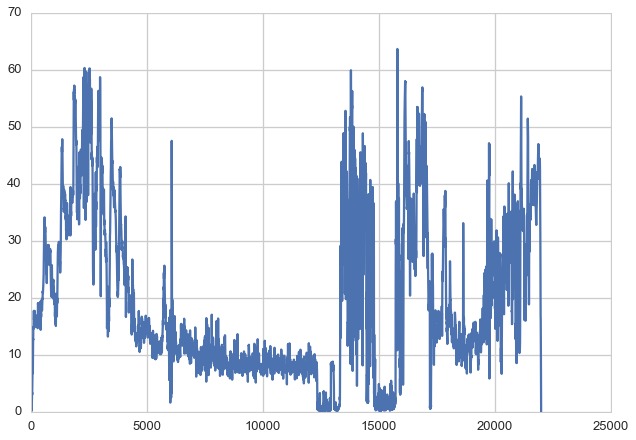

In [42]:
segment.points[0].speed = 0.0
segment.points[-1].speed = 0.0
gpx_file.add_missing_speeds()

speed = np.array([p.speed for p in segment.points])*3.6
plt.plot(speed)

In [43]:
np.argsort(speed)[::-1]

array([15792, 15791,  2315, ..., 12597, 21985,     0])

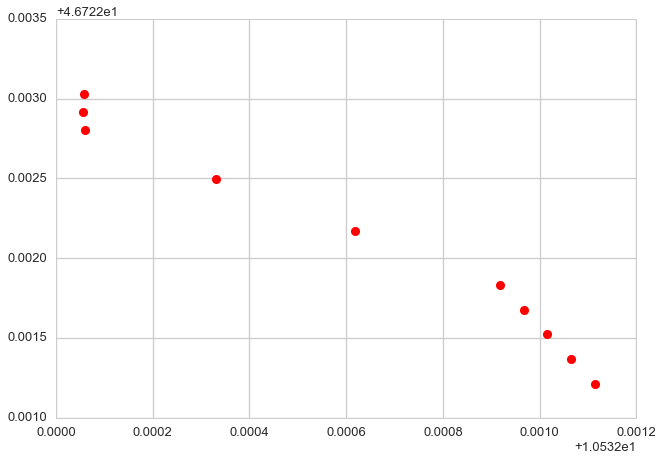

In [44]:
n, p = 2505, 10
plt.plot(measurements[n:n+p,0], measurements[n:n+p,1], 'ro')

In [45]:
segment.points[2540:2570]

[GPXTrackPoint(46.6954197553, 10.537974378, elevation=1117.0370793581849, time=datetime.datetime(2016, 6, 26, 5, 18, 44), speed=16.089576001689558),
 GPXTrackPoint(46.695320882, 10.5381276606, elevation=1116.3076508314791, time=datetime.datetime(2016, 6, 26, 5, 18, 45), speed=16.033515007042013),
 GPXTrackPoint(46.6952221469, 10.5382804074, elevation=1115.5798175868074, time=datetime.datetime(2016, 6, 26, 5, 18, 46), speed=16.025598923116355),
 GPXTrackPoint(46.6951232406, 10.5384333612, elevation=1114.8535688002953, time=datetime.datetime(2016, 6, 26, 5, 18, 47), speed=16.07253513784862),
 GPXTrackPoint(46.6950238172, 10.5385868584, elevation=1114.1289576896388, time=datetime.datetime(2016, 6, 26, 5, 18, 48), speed=16.132939535889378),
 GPXTrackPoint(46.694924145, 10.5387409422, elevation=1113.4059952750497, time=datetime.datetime(2016, 6, 26, 5, 18, 49), speed=16.17613694828139),
 GPXTrackPoint(46.6948246163, 10.5388958549, elevation=1112.6847810701474, time=datetime.datetime(2016, 6

In [46]:
state_vars[2505:2515,:2,:2]

array([[[  3.57717905e-09,   2.62961315e-10],
        [ -2.63018327e-10,   3.57400687e-09]],

       [[  3.57717680e-09,   2.62980851e-10],
        [ -2.63028790e-10,   3.57400962e-09]],

       [[  3.57718213e-09,   2.62969846e-10],
        [ -2.63023119e-10,   3.57400905e-09]],

       [[  3.57717925e-09,   2.62960202e-10],
        [ -2.63019021e-10,   3.57400881e-09]],

       [[  3.57717785e-09,   2.62979249e-10],
        [ -2.63029140e-10,   3.57401201e-09]],

       [[  3.57718053e-09,   2.62965060e-10],
        [ -2.63018887e-10,   3.57400822e-09]],

       [[  3.57717681e-09,   2.62983571e-10],
        [ -2.63029994e-10,   3.57400985e-09]],

       [[  3.57718250e-09,   2.62968320e-10],
        [ -2.63021296e-10,   3.57400728e-09]],

       [[  3.57718141e-09,   2.62956712e-10],
        [ -2.63017269e-10,   3.57400601e-09]],

       [[  3.57717781e-09,   2.62961591e-10],
        [ -2.63018417e-10,   3.57400873e-09]]])